生成数据集

In [60]:
import numpy as np
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l
import numpy as np

n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

初始化模型参数

In [3]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

定义 L2 范数惩罚

In [4]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

训练

In [17]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 ==0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    return torch.norm(w).data

训练

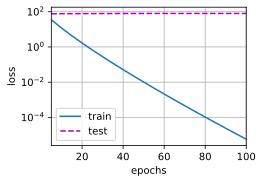

In [74]:
norm_value=train(lambd=0)
norm_value

In [75]:
print(norm_value)

tensor(12.4806)


使用权重衰减

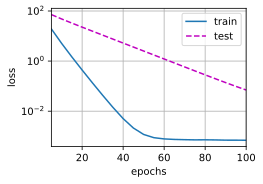

In [36]:
norm_value=train(lambd=3)
norm_value

In [28]:
print(norm_value)

tensor(0.3655)


简洁实现

In [52]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    return net[0].weight.norm().item()

简洁训练

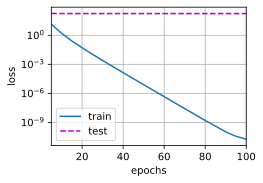

In [53]:
concise_norm = train_concise(0)
concise_norm

In [54]:
print(concise_norm)

14.249305725097656


调整 lambda

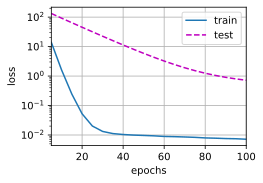

In [55]:
concise_norm = train_concise(3)
concise_norm

In [56]:
print(concise_norm)

0.4233556389808655


练习 4.5.1 在本节的估计问题中使用 λ 的值进行实验。绘制训练和测试精度关于 λ 的函数图。可以观察到什么？

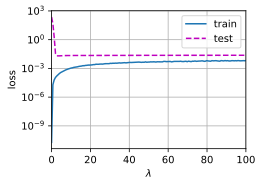

In [67]:
def train_wd(wd_list, train_iter, test_iter):
    norm_value_list = []
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='$\lambda$', ylabel='loss', yscale='log',
                            xlim=[wd_list[0], wd_list[-1]], legend=['train', 'test'])
    for param in net.parameters():
        param.data.normal_()

    for wd in wd_list:
        for i in [0]:
            trainer = torch.optim.SGD([
                {"params":net[i].weight,'weight_decay': wd},
                {"params":net[i].bias}], lr=lr)

        for epoch in range(num_epochs):
            trainer.zero_grad()
            for X, y in train_iter:
                trainer.zero_grad()
                l = loss(net(X), y)
                l.mean().backward()
                trainer.step()

        animator.add(wd,(d2l.evaluate_loss(net, train_iter, loss),
                              d2l.evaluate_loss(net, test_iter, loss)))

        norm_value_list.append(net[0].weight.norm().item())

    return norm_value_list

norm_value_list = train_wd(np.linspace(0, 100, 150), train_iter, test_iter)
norm_value_list

In [73]:
from fractions import Fraction

# 在你的循环中使用 Fraction
for i in range(len(norm_value_list)):
    lambda_fraction = Fraction(2*(i+1), 3)
    print(f"lambda 为 {lambda_fraction} 时的 L2 范数为: {norm_value_list[i]}")

lambda 为 2/3 时的 L2 范数为: 13.921030044555664
lambda 为 4/3 时的 L2 范数为: 6.216705322265625
lambda 为 2 时的 L2 范数为: 1.2383248805999756
lambda 为 8/3 时的 L2 范数为: 0.11541284620761871
lambda 为 10/3 时的 L2 范数为: 0.03242160379886627
lambda 为 4 时的 L2 范数为: 0.029294610023498535
lambda 为 14/3 时的 L2 范数为: 0.027327604591846466
lambda 为 16/3 时的 L2 范数为: 0.026021119207143784
lambda 为 6 时的 L2 范数为: 0.025221697986125946
lambda 为 20/3 时的 L2 范数为: 0.024478208273649216
lambda 为 22/3 时的 L2 范数为: 0.023742329329252243
lambda 为 8 时的 L2 范数为: 0.02313871681690216
lambda 为 26/3 时的 L2 范数为: 0.022566474974155426
lambda 为 28/3 时的 L2 范数为: 0.02204594761133194
lambda 为 10 时的 L2 范数为: 0.021527305245399475
lambda 为 32/3 时的 L2 范数为: 0.020993202924728394
lambda 为 34/3 时的 L2 范数为: 0.020675601437687874
lambda 为 12 时的 L2 范数为: 0.020090682432055473
lambda 为 38/3 时的 L2 范数为: 0.019803963601589203
lambda 为 40/3 时的 L2 范数为: 0.019523296505212784
lambda 为 14 时的 L2 范数为: 0.019152628257870674
lambda 为 44/3 时的 L2 范数为: 0.01857556588947773
lambda 为 46/3 时的 L2 范